# Donations to L.A. County 2nd District Supervisorial Candidates

By [Matt Stiles](https://www.latimes.com/people/matt-stiles) / Los Angeles Times

Data analysis for this story: [These candidates want to represent 2 million Angelenos. Who’s funding their campaigns?](https://www.latimes.com/projects/county-supervisor-2nd-district-campaign-donations/)

Questions? matt.stiles@latimes.com

### Load Python tools

In [1]:
import pandas as pd
import geopandas as gpd
from urllib.request import urlopen 
import pyarrow
import jenkspy
import matplotlib.pyplot as plt
%matplotlib inline
import json
import numpy as np
from altair import datum
import altair as alt
# alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
alt.renderers.set_embed_options(actions=False)

RendererRegistry.enable('default')

### Load all donations candidates since 2007, downloaded [here](https://efs.lacounty.gov/public_search_results.cfm?viewtype=xl&requesttimeout=1000&showall=yes&rept_type=ALLCon&CITY=la&LNM_CRIT=&FNM_CRIT=&CNM_CRIT=&ST_CRIT=&ZIP_CRIT=&ENM_CRIT=&OCC_CRIT=&S_USER=&S_OFFICE=&CID_CRIT=&CMT_CRIT=&D_BDATE=&D_EDATE=&S_BAMT=&S_EAMT=&ELECTION_ID=29&SCHEDULE=A%2CB%2CC&SUBMITBTN=Search%20Now%20%3D%3D%3E&TO_ELEC_DATE=&FROM_RPT_DATE=&TO_RPT_DATE=), and clean headers

In [2]:
src = pd.read_csv('input/county_donations_all_20200219.csv',\
                  dtype={'contributor_zip_code': 'str'}, low_memory=False)

In [3]:
src.columns = src.columns.str.strip().str.lower().str.replace(' ', '_')\
                    .str.replace('(', '').str.replace(')', '').str.replace('-','_')

In [4]:
len(src)

82660

### Create a clean dataframe from the original import

In [5]:
contributions = pd.DataFrame(src)

### Clean up null values the table and other quirks

In [6]:
contributions.contributor_address_2 = contributions.contributor_address_2.fillna('')
contributions.occupation = contributions.occupation.fillna('')
contributions.employer = contributions.employer.fillna('')
contributions.description = contributions.description.fillna('')
contributions.contributor_first_name = contributions.contributor_first_name.fillna('')
contributions.contributor_zip_code_ext = contributions.contributor_zip_code_ext.fillna('')

In [7]:
contributions['amount_rcvd'] = contributions['amount_rcvd'].astype(int)
contributions['monthyear'] = pd.to_datetime(contributions['date']).map(lambda dt: dt.replace(day=1))
contributions['type'] = contributions['type'].str.replace("Small Contributor Committee", "Small Donor Committee")
contributions['first_name'] = contributions['first_name'].str.upper()
contributions['last_name'] = contributions['last_name'].str.upper()
contributions['committee_name'] = contributions['committee_name'].str.upper()
contributions['contributor_zip_code'] = contributions['contributor_zip_code'].astype(str).str.zfill(5)
contributions['contributor_zip_code'] = contributions['contributor_zip_code'].str.replace('.0','',regex=False)

In [8]:
contributions['candidate_name'] =  contributions["first_name"].str.title() + ' ' + contributions["last_name"].str.title()
contributions['candidate_name'] = contributions['candidate_name'].str.replace('Holly J. Mitchell', 'Holly Mitchell')
contributions['first_name'] = contributions['first_name'].str.replace('HOLLY J.', 'HOLLY')

### Change the zip code field so it merges with other tables later

In [9]:
contributions.rename(columns={"contributor_zip_code": "zipcode"}, inplace=True)

### What do the records look like?

In [10]:
contributions.sort_values(by='date', ascending=False).head(1)

last_name first_name committee_id  \
79619  MITCHELL      HOLLY      1415889   

                                     committee_name office_type  \
79619  HOLLY J. MITCHELL FOR COUNTY SUPERVISOR 2020         CSU   

      district_number schedule type period_beg_date period_end_date  ...  \
79619             C02        A    I          7/1/19        12/31/19  ...   

      int_city int_state  int_zip_code  int_occupation int_employer doc_id  \
79619      NaN       NaN           NaN             NaN          NaN    NaN   

      rec_id       x  monthyear  candidate_name  
79619   2671  174577 2019-09-01  Holly Mitchell  

[1 rows x 36 columns]

### Sluggify candidate names

In [11]:
contributions['candidate_slug'] =  \
    contributions["first_name"].str.lower() + '_' + contributions["last_name"].str.lower()
contributions['candidate_slug']\
= contributions['candidate_slug'].\
str.strip().str.lower().str.replace(\
                    ' ', '_').str.replace('(', '').str.replace(')', '')\
.str.replace('.', '').str.replace('\'', '')

### Process the dates now to make life easier througout

In [12]:
contributions['date'] = pd.to_datetime(contributions['date'])
contributions['year'], contributions['month'] = contributions['date'].dt.year, contributions['date'].dt.month
contributions['year'] = contributions['year'].astype(str)
contributions['month'] = contributions['month'].astype(str)
contributions['months'] = contributions['date'].dt.strftime('%m/%Y').astype(str)
contributions['week'] = contributions['date'].dt.week
contributions['week'] = contributions['week'].astype(str)

### Chan Jeong and Jake Jeong are the same person. Standardize the names for better aggregates. 

In [13]:
contributions.loc[(contributions.candidate_name == 'Chan Jeong'),'candidate_name']='Jake Jeong'

In [14]:
contributions.head(1)

last_name first_name committee_id                           committee_name  \
0    COOLEY      STEVE      1293554  COMMITTEE TO RE-ELECT D.A. STEVE COOLEY   

  office_type district_number schedule type period_beg_date period_end_date  \
0         DAT             Cna        A    I          1/1/07         6/30/07   

   ... doc_id rec_id     x  monthyear candidate_name candidate_slug  year  \
0  ...    NaN     33  3368 2007-05-01   Steve Cooley   steve_cooley  2007   

   month   months week  
0      5  05/2007   20  

[1 rows x 41 columns]

### Filter data for recent contributions and money in the District 2 race

In [15]:
recent_contributions = contributions[(contributions['date'] > '2018-06-30')]

In [16]:
recent_contributions[recent_contributions['candidate_name'] == 'Jake Jeong']['amount_rcvd'].sum()

106898

### Define the 2nd District candidates

In [17]:
second_district_candidates = (['Holly Mitchell','Herb Wesson',\
                               'Jan Perry','Chan Jeong', 'Jorge Nuno', \
                               'Albert Robles','Jake Jeong'])

### Make a dataframe with only 2nd District donations

In [18]:
districttwo = pd.DataFrame(recent_contributions[recent_contributions['candidate_name']\
                                                .isin(second_district_candidates)])

In [19]:
districttwo[districttwo['candidate_name']== 'Jake Jeong']['amount_rcvd'].sum()

106898

### How many donations are we talking about? 

In [20]:
len(districttwo)

4796

In [21]:
districttwo.candidate_name.value_counts()

Holly Mitchell    1552
Jan Perry         1539
Herb Wesson       1448
Jake Jeong         186
Albert Robles       38
Jorge Nuno          33
Name: candidate_name, dtype: int64

### How much did the candidates raise individually? 

In [22]:
second_district_totals = districttwo.groupby(['candidate_name'])['amount_rcvd']\
    .sum().reset_index().sort_values(by='amount_rcvd', ascending=False)

In [23]:
second_district_totals

candidate_name  amount_rcvd
1     Herb Wesson      1471623
2  Holly Mitchell       900553
4       Jan Perry       722654
3      Jake Jeong       106898
0   Albert Robles        41000
5      Jorge Nuno        12650

In [24]:
sum_all_donations = second_district_totals['amount_rcvd'].sum()

### And how much has been raised by the candidates in total?

In [25]:
second_district_totals['amount_rcvd'].sum()

3255378

In [26]:
second_district_sum = districttwo.groupby(['candidate_name'])['amount_rcvd']\
    .sum().reset_index().sort_values(by='candidate_name', ascending=False)
second_district_sum.head(10)

candidate_name  amount_rcvd
5      Jorge Nuno        12650
4       Jan Perry       722654
3      Jake Jeong       106898
2  Holly Mitchell       900553
1     Herb Wesson      1471623
0   Albert Robles        41000

In [27]:
second_district_avg = districttwo.groupby(['candidate_name'])['amount_rcvd']\
    .mean().reset_index().sort_values(by='candidate_name', ascending=False)

### What is each candidate's average donation size? 

In [28]:
second_district_avg.round(2)

candidate_name  amount_rcvd
5      Jorge Nuno       383.33
4       Jan Perry       469.56
3      Jake Jeong       574.72
2  Holly Mitchell       580.25
1     Herb Wesson      1016.31
0   Albert Robles      1078.95

In [29]:
districttwo.to_csv('output/district_two.csv')

### How many individual donations did each candidate receive? 

In [30]:
# Crudely remap donation 'type' codes to be more descriptive
abbr_indiv_else = {'C' : 'Other', 'I' : 'Individual', 'O' : 'Other', 'S' : 'Other'}
districttwo = districttwo.replace({"type": abbr_indiv_else})

In [31]:
second_district_indiv = pd.pivot_table(districttwo, values='amount_rcvd', \
                    index=['candidate_name'], columns=['type'], aggfunc=[np.size], fill_value='0').reset_index()

In [32]:
second_district_indiv = pd.DataFrame(second_district_indiv.to_records())

In [33]:
second_district_indiv.columns = second_district_indiv.columns.str.strip().str.lower().str.replace(',_', '')\
                    .str.replace('(', '').str.replace(')', '').str.replace("'", '')\
                    .str.replace('size, ','').str.replace(',', '')

In [34]:
second_district_indiv = pd.DataFrame(second_district_indiv)

### Which share of each candidates donations came from individuals?

In [35]:
second_district_indiv.head()

index candidate_name   individual  other
0      0   Albert Robles          13     25
1      1     Herb Wesson         976    472
2      2  Holly Mitchell        1165    387
3      3      Jake Jeong         137     49
4      4       Jan Perry        1412    127

In [36]:
second_district_indiv['share_indy'] = \
    ((second_district_indiv['individual'] /\
      (second_district_indiv['individual'] + second_district_indiv['other']))*100).round()

In [37]:
second_district_indiv['share_other'] = \
    ((second_district_indiv['other'] /\
      (second_district_indiv['individual'] + second_district_indiv['other']))*100).round()

In [38]:
second_district_indiv.head()

index candidate_name   individual  other  share_indy  share_other
0      0   Albert Robles          13     25        34.0         66.0
1      1     Herb Wesson         976    472        67.0         33.0
2      2  Holly Mitchell        1165    387        75.0         25.0
3      3      Jake Jeong         137     49        74.0         26.0
4      4       Jan Perry        1412    127        92.0          8.0

### Normalized bar chart for the share of individual donations

In [39]:
bars = alt.Chart(districttwo, title='Share of donations from individuals').mark_bar().encode(
    x=alt.X('sum(amount_rcvd)', stack="normalize", title="Share of donations",axis=alt.Axis(format='%', tickCount=6)),
    y=alt.Y('candidate_name', title=""),
    color=alt.Color('type',legend=alt.Legend(title="", orient='top')),
    order=alt.Order('sum(amount_rcvd)', sort='ascending')
)
(bars).properties(height=175, width=800)

alt.Chart(...)

## When exactly is each donation? 

### How much did each candidate raise — by month — in 2019? 

In [40]:
districttwo_time = districttwo.groupby(['monthyear','year','month', 'candidate_name'], as_index=False).\
            agg({'amount_rcvd': ['size', 'mean', 'sum']}, as_index=False)

flat_columns = [''.join(t) for t in districttwo_time.columns]
districttwo_time.columns = flat_columns
districttwo_time['amount_rcvdmean'] = districttwo_time['amount_rcvdmean'].astype(int)
districttwo_time['amount_rcvdmean'] = districttwo_time['amount_rcvdmean'].round()
districttwo_time.head(10)
districttwo_time['months'] = districttwo_time['monthyear'].dt.strftime('%b').astype(str)
districttwo_time['week'] = districttwo_time['monthyear'].dt.week

In [41]:
districttwo_time = districttwo_time[(districttwo_time.year == '2019')]

In [42]:
districttwo_time[(districttwo_time.candidate_name == 'Jake Jeong')][['candidate_name', 'months', 'amount_rcvdsum']]

candidate_name months  amount_rcvdsum
14     Jake Jeong    May           45100
18     Jake Jeong    Jun            1000
22     Jake Jeong    Jul            5800
26     Jake Jeong    Aug            3050
30     Jake Jeong    Sep            3700
34     Jake Jeong    Oct           23050
38     Jake Jeong    Nov            6000
44     Jake Jeong    Dec           14198

In [43]:
second_district_totals

candidate_name  amount_rcvd
1     Herb Wesson      1471623
2  Holly Mitchell       900553
4       Jan Perry       722654
3      Jake Jeong       106898
0   Albert Robles        41000
5      Jorge Nuno        12650

In [44]:
alt.Chart(districttwo_time).mark_bar().encode(
    y='amount_rcvdsum:Q',
    x=alt.X('month:N', timeUnit='month', title='')
).properties(
    width=250,
    height=180
).facet(
    facet='candidate_name:N',
    columns=3
)

alt.FacetChart(...)

In [45]:
districttwo_time[districttwo_time['candidate_name'] == 'Albert Robles']

monthyear  year month candidate_name  amount_rcvdsize  amount_rcvdmean  \
41 2019-12-01  2019    12  Albert Robles               37             1081   

    amount_rcvdsum months  week  
41           40000    Dec    48

In [46]:
districttwo_time.to_csv('output/districttwo_time.csv')

### How much did they raise by ZIP? 

In [47]:
zip_totals = districttwo.groupby(['zipcode'])['amount_rcvd']\
    .sum().reset_index().sort_values(by='amount_rcvd', ascending=False)

In [48]:
zip_totals.head(10)

zipcode  amount_rcvd
685   95814       101450
179   90010        86650
219   90049        68199
240   90210        62080
186   90017        61203
193   90024        53350
177   90008        52837
189   90020        49250
188   90019        47505
220   90056        47195

In [49]:
zip_totals.to_csv('output/zip_totals.csv')

In [50]:
zip_totals_candidates = districttwo.groupby(['candidate_name', 'zipcode'])['amount_rcvd']\
    .sum().reset_index().sort_values(by='amount_rcvd', ascending=False)

### Top ZIP Code for any candidate?

In [51]:
zip_totals_candidates[zip_totals_candidates['candidate_name'] == 'Jake Jeong'].head()

candidate_name zipcode  amount_rcvd
833     Jake Jeong   90010        22550
831     Jake Jeong   90005        11800
840     Jake Jeong   90020         7250
837     Jake Jeong   90017         6000
852     Jake Jeong   90058         4750

---

## Geography

### Load 2nd District boundary data

In [52]:
#http://public.gis.lacounty.gov/public/rest/services/LACounty_Dynamic/Demographics/MapServer/3
district = gpd.read_file('/Users/mhustiles/data/data/GIS/LA/second-district.geojson')

### Read the zip codes boundaries

In [53]:
#http://public.gis.lacounty.gov/public/rest/services/LACounty_Dynamic/Administrative_Boundaries/MapServer/5
# zips_old = gpd.read_file('/Users/mhustiles/data/github/notebooks/\
# campaign-finance/input/la_county_gis_zip_codes/la_county_gis_zip_codes_1569271283260.geojson')
zips = gpd.read_file('/Users/mhustiles/data/github/AGStoShapefile/\
backupdir/WealthiestZipCodes2017/WealthiestZipCodesCA.geojson')

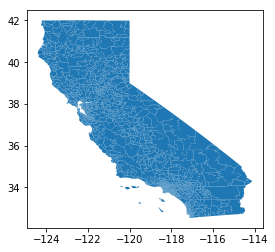

In [54]:
zips.plot()

In [55]:
zips = gpd.GeoDataFrame(zips[zips['COUNTY_NAME'].str.contains('Los Angeles County')])

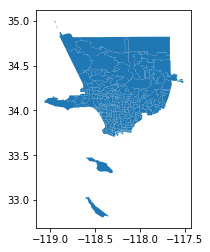

In [56]:
zips.plot()

In [57]:
zips.columns = zips.columns.str.strip().str.lower().str.replace(' ', '_')\
    .str.replace('(', '').str.replace(')', '')

In [58]:
zips.rename(columns={"id": "zipcode"}, inplace=True)
zips.crs = {'init': 'epsg:4326'}

In [59]:
zips.drop(['objectid',
           'st_abbrev',
          'hai_cy',
          'incmort_cy',
          'wlthrnk_cy',
          'domstate',
           'domcbsa',
           'cbsa_name',
           'shape__area',
           'shape__length',
           'avgnw_cy',
          'county_name'], axis=1, inplace=True)

In [60]:
zips.loc[0]

zipcode                                                   90001
name                                                Los Angeles
domcounty                                                 06037
totpop_cy                                                 59907
tothh_cy                                                  13454
medage_cy                                                  27.1
avghinc_cy                                                46931
avgval_cy                                                377591
geometry      POLYGON ((-118.247540000384 33.9890800002533, ...
Name: 0, dtype: object

In [61]:
zips_in_district = gpd.sjoin(zips, district, how="inner", op='intersects')

### Export 2nd District boundary data to MBTiles

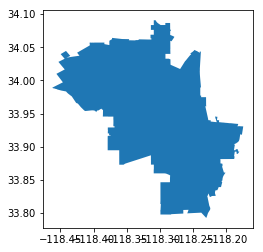

In [62]:
district.plot()

### Only zips that overlap with the district

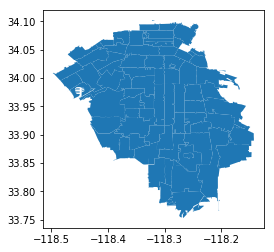

In [63]:
zips_in_district.plot()

In [64]:
zips_in_district.rename(columns={"id": "zipcode"}, inplace=True)

In [65]:
zips_in_district_geo = zips_in_district.merge(zip_totals, on='zipcode')

In [66]:
zips_in_district_geo['amount_rcvd'] = zips_in_district_geo['amount_rcvd'].astype(float).fillna('0')

In [67]:
zips_in_district_geo.sort_values(by='amount_rcvd', ascending=False).head(1)

zipcode         name domcounty  totpop_cy  tothh_cy  medage_cy  avghinc_cy  \
7   90010  Los Angeles     06037        496       276       38.6       53753   

   avgval_cy                                           geometry  index_right  \
7     488690  MULTIPOLYGON (((-118.31437 34.06092, -118.3143...            0   

   OBJECTID DISTRICT       LABEL  Shape.STArea()  Shape.STLength()  \
7       816        2  District 2    4.511283e+09     477421.592662   

   amount_rcvd  
7      86650.0

In [68]:
zips_in_district_geo.dtypes

zipcode               object
name                  object
domcounty             object
totpop_cy              int64
tothh_cy               int64
medage_cy            float64
avghinc_cy             int64
avgval_cy              int64
geometry            geometry
index_right            int64
OBJECTID               int64
DISTRICT              object
LABEL                 object
Shape.STArea()       float64
Shape.STLength()     float64
amount_rcvd          float64
dtype: object

In [69]:
zips_in_district_export = gpd.GeoDataFrame(zips_in_district_geo)

### Export file showing all donations by distrit zips

In [70]:
zips_in_district_export.to_file('output/zips_in_district_export.shp')

---

### How much did each of the candidates raise, by zip?

In [119]:
# pivot to a wide table for mapping

sum_by_zip = pd.pivot_table(districttwo, values='amount_rcvd', index=['zipcode'], 
                            columns=['candidate_slug'], aggfunc=np.sum, fill_value=0).reset_index()

In [72]:
sum_by_zip["total"] = sum_by_zip.sum(axis=1)

In [121]:
# flatten the multiindex frame

sum_by_zip.columns = sum_by_zip.columns.to_series().str.join('')

### How much did all of the candidates raise by zip?

In [74]:
sum_by_zip = sum_by_zip.sort_values("total", ascending=False)

In [75]:
sum_by_zip.head()

candidate_slug zipcode  albert_robles  chan_jeong  herb_wesson  \
685              95814              0           0        12300   
179              90010              0        4600        52450   
219              90049              0           0        23949   
240              90210              0           0        29950   
186              90017              0        4000        27488   

candidate_slug  holly_mitchell  jake_jeong  jan_perry  jorge_nuno   total  
685                      89150           0          0           0  101450  
179                       5300       17950       6350           0   86650  
219                      13400           0      30850           0   68199  
240                       6700           0      25430           0   62080  
186                      15015        2000      12600         100   61203

### Top ZIP Codes

In [118]:
sum_by_zip[['zipcode', 'total']].sort_values(by='total', ascending=False).head()

candidate_slug zipcode   total
685              95814  101450
179              90010   86650
219              90049   68199
240              90210   62080
186              90017   61203

### How many zips donated? 

In [77]:
sum_by_zip.total.count()

715

### Which 2nd District candidate received the most in each zip? 

In [78]:
#create a dummy field because i'm bad at idxmax; 
sum_by_zip['tie'] = '0'

In [79]:
#reshape dataframe
sum_by_zip_winner = pd.DataFrame(sum_by_zip[['zipcode', 'tie','jake_jeong',\
                                             'herb_wesson','jan_perry','holly_mitchell',
                                             'jorge_nuno', 'chan_jeong','albert_robles','total']])

### Candidate Jeong changed his name mid-cycle. Clean that up.

In [80]:
sum_by_zip_winner['jake_jeong'] = sum_by_zip_winner['jake_jeong'] + sum_by_zip_winner['chan_jeong']

In [81]:
sum_by_zip_winner.drop(['chan_jeong'], axis=1, inplace=True)

In [82]:
sum_by_zip_winner['tie'] = sum_by_zip_winner['tie'].astype(int)
sum_by_zip_winner['zipcode'] = sum_by_zip_winner['zipcode'].astype(str)

### Who won each zip?

In [83]:
sum_by_zip_winner['winner_dist_two'] = sum_by_zip_winner[['tie','jake_jeong','herb_wesson','jan_perry','holly_mitchell']].idxmax(axis=1)

### How much did each zip winner raise from there? 

In [84]:
sum_by_zip_winner['winner_total'] = sum_by_zip_winner[['tie','jake_jeong','herb_wesson','jan_perry','holly_mitchell','jorge_nuno', 'albert_robles']].max(axis=1)

In [85]:
sum_by_zip_winner['winner_dist_two']= sum_by_zip_winner['winner_dist_two'].str.title().str.replace('_',' ')

In [86]:
sum_by_zip_winner['winner_dist_two'].value_counts('normalize')

Herb Wesson       0.416783
Holly Mitchell    0.363636
Jan Perry         0.183217
Tie               0.019580
Jake Jeong        0.016783
Name: winner_dist_two, dtype: float64

### Which were the top zips for each candidate? 

In [87]:
sum_by_zip_winner.sort_values(by='winner_total', ascending=False).head()

candidate_slug zipcode  tie  jake_jeong  herb_wesson  jan_perry  \
685              95814    0           0        12300          0   
179              90010    0       22550        52450       6350   
219              90049    0           0        23949      30850   
240              90210    0           0        29950      25430   
189              90020    0        7250        28400       8600   

candidate_slug  holly_mitchell  jorge_nuno  albert_robles   total  \
685                      89150           0              0  101450   
179                       5300           0              0   86650   
219                      13400           0              0   68199   
240                       6700           0              0   62080   
189                       5000           0              0   49250   

candidate_slug winner_dist_two  winner_total  
685             Holly Mitchell         89150  
179                Herb Wesson         52450  
219                  Jan Perry         30850  
240                Herb Wesson         29950  
189                Herb Wesson         28400

In [88]:
sum_by_zip_winner.to_csv('output/sum_by_hood_winner.csv')

### Remove rows with no contributions

In [89]:
sum_by_zip_winner = sum_by_zip_winner[(sum_by_zip_winner['winner_total'] != 0)]

In [90]:
len(sum_by_zip_winner)

715

### How many zips did each candidate win?

In [91]:
sum_by_zip_winner.winner_dist_two.value_counts()

Herb Wesson       298
Holly Mitchell    260
Jan Perry         131
Tie                14
Jake Jeong         12
Name: winner_dist_two, dtype: int64

---

### How much did the candidates raise in the 2nd District ZIPs alone? 

In [93]:
donations_in_district_zips = zips_in_district.merge(zip_totals_candidates,on='zipcode')

### Share raised inside the district raised by all the candidates? 

In [94]:
((donations_in_district_zips.amount_rcvd.sum() /second_district_totals['amount_rcvd'].sum()) * 100).round(3)

35.609

### Share raised inside the district raised by each candidate? 

In [95]:
in_district_totals = donations_in_district_zips.groupby(['candidate_name']).agg('sum').reset_index()

In [96]:
in_district_totals[['candidate_name','amount_rcvd']]

candidate_name  amount_rcvd
0   Albert Robles         4750
1     Herb Wesson       578280
2  Holly Mitchell       211495
3      Jake Jeong        66150
4       Jan Perry       289479
5      Jorge Nuno         9050

In [97]:
in_district_share = in_district_totals.merge(second_district_sum, on='candidate_name')
in_district_share_slim = pd.DataFrame(in_district_share[['candidate_name','amount_rcvd_y', 'amount_rcvd_x']])

In [98]:
in_district_share.head(10)

candidate_name  totpop_cy  tothh_cy  medage_cy  avghinc_cy  avgval_cy  \
0   Albert Robles     179681     58360      231.7      544376    3428568   
1     Herb Wesson    2828116    942826     2549.4     5709394   43606012   
2  Holly Mitchell    1933225    713582     2088.3     4875258   37636332   
3      Jake Jeong     885572    304275      725.0     1325028   12384168   
4       Jan Perry    2239647    800693     2314.9     5257774   40888393   
5      Jorge Nuno     480795    128479      246.1      542633    4055818   

   index_right  OBJECTID  Shape.STArea()  Shape.STLength()  amount_rcvd_x  \
0            0      4896    2.706770e+10      2.864530e+06           4750   
1            0     57120    3.157898e+11      3.341951e+07         578280   
2            0     44880    2.481206e+11      2.625819e+07         211495   
3            0     17136    9.473694e+10      1.002585e+07          66150   
4            0     50592    2.796996e+11      2.960014e+07         289479   
5            0      5712    3.157898e+10      3.341951e+06           9050   

   amount_rcvd_y  
0          41000  
1        1471623  
2         900553  
3         106898  
4         722654  
5          12650

### What share did candidates raise from outside the district?

In [99]:
in_district_share_slim.rename(columns={"amount_rcvd_y": "total_raised",\
                                      "amount_rcvd_x": "inside_raised"}, inplace=True)

In [100]:
in_district_share_slim['share_inside'] = ((in_district_share_slim['inside_raised'] /\
                                   in_district_share_slim['total_raised'] ) *100).round()

In [101]:
in_district_share_slim['share_outside'] = 100 - in_district_share_slim['share_inside']

In [102]:
in_district_share_slim.head(6)

candidate_name  total_raised  inside_raised  share_inside  share_outside
0   Albert Robles         41000           4750          12.0           88.0
1     Herb Wesson       1471623         578280          39.0           61.0
2  Holly Mitchell        900553         211495          23.0           77.0
3      Jake Jeong        106898          66150          62.0           38.0
4       Jan Perry        722654         289479          40.0           60.0
5      Jorge Nuno         12650           9050          72.0           28.0

In [103]:
in_district_share_slim[['candidate_name','share_inside','share_outside']]\
    .to_csv('output/in_district_share_slim.csv')

### Merge the geography back onto our 2nd District winners table

In [104]:
totals_by_LA_zips = zips.merge(sum_by_zip_winner, on='zipcode')

In [105]:
totals_by_LA_zips_slim = totals_by_LA_zips[['zipcode','geometry','herb_wesson','jan_perry','holly_mitchell',  \
                                           'tie','jake_jeong','total','winner_dist_two','winner_total']]

### Export geojson for web app and Turf

In [106]:
totals_by_LA_zips_slim.to_file('output/second-district-zips-update.geojson', driver='GeoJSON')
totals_by_LA_zips_slim.to_file('/Users/mhustiles/data/github/bigbuilder/bigbuilder/pages/county-supervisor-2nd-district-campaign-donations/static/second-district-zips-update.geojson', driver='GeoJSON')

### Generate winners by zips to MBTiles for Mapbox

In [107]:
!tippecanoe --generate-ids --force -r1 -pk -pf -o \
output/second-district-zips-update.mbtiles \
output/second-district-zips-update.geojson

For layer 0, using name "seconddistrictzipsupdate"
243 features, 322870 bytes of geometry, 5502 bytes of separate metadata, 3789 bytes of string pool
  99.9%  14/2800/6535  


---

### Wesson donations

In [108]:
wesson = districttwo[districttwo['candidate_name'] == 'Herb Wesson']

In [109]:
wessonoutside = wesson[wesson['type'] == 'Other']

In [110]:
wessonlarge = wesson[wesson['amount_rcvd'] == 1500]
len(wessonlarge)

702

### Mitchell donations

In [111]:
mitchell = districttwo[districttwo['candidate_name'] == 'Holly Mitchell']

In [112]:
mitchelloutside = mitchell[mitchell['type'] == 'Other']

In [113]:
mitchelllarge = mitchell[mitchell['amount_rcvd'] == 1500]
len(mitchelllarge)

316

### Perry donations

In [114]:
perry = districttwo[districttwo['candidate_name'] == 'Jan Perry']

In [115]:
perryoutside = perry[perry['type'] == 'Other']

In [116]:
perrylarge = perry[perry['amount_rcvd'] == 1500]
len(perrylarge)

213